# Stock Selection via Categorical Gradient Boosting

Basic idea: take 70 accounting ratios used in valuation, make an AI recommendation system for stock selection. The AI recommends a portfolio of stocks to buy or to sell. <br>
We do this by using the Python package `CatBoost` developed by Yandex. We take these valuation ratios as our features, and use ranking loss to predict stock return direction of the next month 

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats.mstats import winsorize
%matplotlib inline
plt.style.use('ggplot')

## Trading Universe
Following Asness et al "Value and Momentum Everywhere", we only trade liquid stocks. <br>
The criteria for liquid stocks is for each month, only select stocks that accounted for accumulatively 90% of the total Market Capitalization.

In [0]:
fundq = pd.read_csv('/gdrive/My Drive/dl-project/fundq.zip', compression='zip', parse_dates=[0], index_col=[0, 1])
fundq = fundq[fundq['TICKER'].notnull()]

In [0]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [0]:
fundq.head()

TICKER   CAPEI     bm     evm  pe_op_basic  pe_op_dil  \
date       PERMNO                                                         
1970-01-30 10102      AN   7.889  0.790   8.730          NaN        NaN   
           10137     AYP  11.110  0.630   9.757          NaN        NaN   
           10145     ACD   9.049  0.744   7.378          NaN        NaN   
           10161     AMX  13.710  0.581  12.373          NaN        NaN   
           10225     AMB  10.152  0.709   6.552          NaN        NaN   

                   pe_exi  pe_inc     ps     pcf    dpr    npm  opmbd  opmad  \
date       PERMNO                                                              
1970-01-30 10102   10.692  10.692  0.396   4.095  0.000  0.040  0.134  0.077   
           10137    5.039  10.132  1.628   5.225  0.158  0.182  0.472  0.346   
           10145   16.096  36.719  0.492   3.650  0.000  0.041  0.150  0.056   
           10161   11.552  10.614  1.142  16.207  0.006  0.099  0.144  0.098   
           10225    9.199   9.199  0.336  -7.256  0.000  0.037  0.221  0.201   

                     gpm   ptpm    cfm    roa    roe   roce  efftax  \
date       PERMNO                                                     
1970-01-30 10102   0.286  0.061  0.097  0.125  0.066  0.091   0.348   
           10137   0.472  0.286  0.312  0.122  0.138  0.115   0.398   
           10145   0.255  0.052  0.135  0.127  0.053  0.059   0.269   
           10161   0.218  0.134  0.150  0.112  0.135  0.093   0.228   
           10225   0.435  0.089  0.104  0.191  0.129  0.208   0.529   

                   aftret_eq  aftret_invcapx  aftret_equity  pretret_noa  \
date       PERMNO                                                          
1970-01-30 10102       0.080           0.063          0.080        0.084   
           10137       0.135           0.075          0.112        0.100   
           10145       0.055           0.055          0.055        0.062   
           10161       0.140           0.116          0.137        0.101   
           10225       0.131           0.136          0.131        0.243   

                   pretret_earnat  GProf  equity_invcap  debt_invcap  \
date       PERMNO                                                      
1970-01-30 10102            0.076  0.251          0.619        0.381   
           10137            0.092  0.114          0.309        0.558   
           10145            0.052  0.218          0.646        0.354   
           10161            0.086  0.159          0.689        0.294   
           10225            0.185  0.322          0.616        0.305   

                   totdebt_invcap  capital_ratio  int_debt  int_totdebt  \
date       PERMNO                                                         
1970-01-30 10102            0.387          0.381     0.054        0.053   
           10137            0.582          0.558     0.048        0.047   
           10145            0.391          0.354     0.063        0.056   
           10161            0.309          0.294     0.049        0.047   
           10225            0.438          0.331     0.076        0.049   

                   cash_lt  invt_act  rect_act  debt_at  debt_ebitda  \
date       PERMNO                                                      
1970-01-30 10102     0.067     0.504     0.393    0.306        2.531   
           10137       NaN       NaN       NaN    0.510        4.480   
           10145     0.041     0.389     0.547    0.293        2.233   
           10161     0.414     0.358     0.261    0.255        2.434   
           10225     0.057     0.777     0.168    0.334        2.042   

                   short_debt  curr_debt  lt_debt  profit_lct  ocf_lct  \
date       PERMNO                                                        
1970-01-30 10102        0.015      0.209    0.592       1.138    0.737   
           10137        0.041      0.129    0.798       1.441    0.915   
           10145        0.094      0.261    0.515       0.978    0.7

In [0]:
features = fundq.columns[1:-8]

In [0]:
features

Index(['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc',
       'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm',
       'roa', 'roe', 'roce', 'efftax', 'aftret_eq', 'aftret_invcapx',
       'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf',
       'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio',
       'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct',
       'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets',
       'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
       'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing',
       'DIVYIELD'],
      dtype='object')

## Normalization
Take data one month at a time, normalize all features across difference stocks

In [0]:
def normalize_features(group):
#     group[features.tolist()] = group[features.tolist()].apply(winsor, axis=0).copy()
    group[features.tolist()] = ((group[features.tolist()] - group[features.tolist()].mean()) / group[features.tolist()].std()).values
    return group

In [0]:
df = fundq.groupby(level=0).apply(normalize_features)

In [0]:
df.describe()

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,DIVYIELD,VOL,SHROUT,MKTCAP,PRC,RET,RET_shifted,pct_rank,label
count,5.221970e+05,5.384740e+05,5.385840e+05,3.544420e+05,2.204620e+05,5.262220e+05,5.259140e+05,5.390950e+05,5.379070e+05,5.299450e+05,5.390950e+05,5.390630e+05,5.390630e+05,5.389930e+05,5.390950e+05,5.115220e+05,5.379850e+05,5.361680e+05,5.329110e+05,5.280780e+05,5.388260e+05,5.370010e+05,5.388240e+05,4.627180e+05,4.688970e+05,5.395540e+05,5.401160e+05,5.392690e+05,5.387160e+05,5.393180e+05,4.709760e+05,4.744040e+05,5.365720e+05,4.675280e+05,4.680290e+05,5.386770e+05,5.375140e+05,5.273640e+05,4.697780e+05,5.391790e+05,4.683150e+05,4.675620e+05,5.359740e+05,4.867660e+05,5.346510e+05,5.373420e+05,5.395860e+05,5.295040e+05,5.395330e+05,4.791040e+05,4.790600e+05,4.669430e+05,4.649940e+05,4.679270e+05,4.548640e+05,4.656940e+05,5.378200e+05,5.301230e+05,5.124260e+05,5.389410e+05,5.370060e+05,4.521120e+05,5.404400e+05,5.388900e+05,5.388900e+05,5.380480e+05,5.384740e+05,4.737710e+05,4.088840e+05,5.276880e+05,5.412100e+05,5.412100e+05,541210.000000,541210.000000,541210.000000,541210.000000,541210.000000
mean,-3.807682e-18,1.212439e-16,1.917431e-17,2.758001e-17,-2.888991e-17,-2.429223e-18,6.269564e-18,-8.893811e-18,-2.473955e-17,3.434415e-17,1.372223e-16,2.572399e-17,9.564020e-17,6.603719e-17,7.336138e-17,-1.318822e-16,-2.392740e-16,-7.323789e-17,5.925956e-17,-9.612540e-17,-2.171501e-17,-2.408632e-17,1.561268e-17,1.610804e-18,-5.282886e-18,1.460809e-16,-5.495898e-16,3.407431e-16,1.458687e-16,2.888038e-16,4.035569e-17,1.995702e-16,1.343246e-16,1.176386e-17,2.456359e-17,2.058417e-16,-2.488198e-17,2.237531e-16,5.025522e-17,6.744832e-16,1.307783e-17,-1.216334e-16,-5.497031e-17,-2.659316e-18,5.744742e-19,8.008384e-17,-3.657514e-17,1.144504e-16,-2.571455e-17,1.333566e-17,-5.953463e-18,2.033763e-17,-2.297332e-17,-1.922366e-16,-7.941368e-18,2.373380e-18,-9.579967e-17,5.785060e-18,1.292920e-17,-5.403196e-18,6.368748e-18,-1.117917e-17,1.164198e-17,3.432296e-16,-2.826166e-17,6.850208e-17,-2.217089e-17,-2.262622e-17,-3.314508e-17,2.985320e+05,1.825101e+05,7.882747e+06,107.679468,0.018053,0.017004,0.500553,0.020354
std,9.994388e-01,9.994557e-01,9.994558e-01,9.994539e-01,9.993693e-01,9.994430e-01,9.994427e-01,9.994563e-01,9.994551e-01,9.994470e-01,9.994563e-01,9.994563e-01,9.994563e-01,9.994562e-01,9.994563e-01,9.994270e-01,9.994552e-01,9.994534e-01,9.994500e-01,9.994450e-01,9.994561e-01,9.994542e-01,9.994561e-01,9.993666e-01,9.993749e-01,9.994568e-01,9.994574e-01,9.994565e-01,9.994560e-01,9.994566e-01,9.993777e-01,9.993822e-01,9.994538e-01,9.993731e-01,9.993738e-01,9.994559e-01,9.994547e-01,9.994443e-01,9.993761e-01,9.994564e-01,9.993742e-01,9.993731e-01,9.994532e-01,9.993979e-01,9.994518e-01,9.994546e-01,9.994568e-01,9.994465e-01,9.994568e-01,9.993883e-01,9.993882e-01,9.993723e-01,9.993697e-01,9.993736e-01,9.993556e-01,9.993706e-01,9.994551e-01,9.994471e-01,9.994280e-01,9.994562e-01,9.994542e-01,9.993517e-01,9.994577e-01,9.994561e-01,9.994561e-01,9.994553e-01,9.994557e-01,9.993814e-01,9.992832e-01,1.380222e+06,5.711361e+05,2.568818e+07,3167.841019,0.108861,0.106923,0.288667,0.748048
min,-3.571974e+01,-2.021363e+00,-3.776764e+01,-1.463929e+01,-1.240093e+01,-1.300790e+01,-1.188047e+01,-1.045718e+00,-1.237397e+01,-3.629652e+01,-3.780146e+01,-3.782762e+01,-3.780965e+01,-3.734489e+01,-3.761607e+01,-3.759177e+01,-3.188970e+01,-3.394122e+01,-3.625148e+01,-3.188049e+01,-3.624781e+01,-3.588191

In [0]:
training_set = df.loc[:'2012-12-31']
testing_set = df.loc['2012-12-31':]
X, y = training_set[features.tolist()], training_set['label']
X_test, y_test = testing_set[features.tolist()], testing_set['label']

In [0]:
training_set.head()

TICKER     CAPEI        bm       evm  pe_op_basic  \
date       PERMNO                                                     
1970-01-30 10102      AN -0.566124  1.209906 -0.049722          NaN   
           10137     AYP -0.466811  0.619525 -0.044108          NaN   
           10145     ACD -0.530358  1.040171 -0.057112          NaN   
           10161     AMX -0.386646  0.438721 -0.029808          NaN   
           10225     AMB -0.496349  0.911026 -0.061627          NaN   

                   pe_op_dil    pe_exi    pe_inc        ps       pcf  \
date       PERMNO                                                      
1970-01-30 10102         NaN -0.525652 -0.595862 -0.671666 -0.196177   
           10137         NaN -0.873740 -0.635149 -0.038628 -0.176785   
           10145         NaN -0.192896  1.230053 -0.622339 -0.203814   
           10161         NaN -0.472696 -0.601334 -0.288349  0.011679   
           10225         NaN -0.617584 -0.700603 -0.702496 -0.390973   

                        dpr       npm     opmbd     opmad       gpm      ptpm  \
date       PERMNO                                                               
1970-01-30 10102  -0.336791 -0.226419 -0.584434 -0.769637 -0.470484 -0.378830   
           10137   0.175364  0.312462  1.828083  1.574091  0.727335  0.429824   
           10145  -0.336791 -0.222624 -0.470232 -0.952604 -0.670120 -0.411177   
           10161  -0.317342 -0.002518 -0.513058 -0.586669 -0.908396 -0.116467   
           10225  -0.336791 -0.237804  0.036539  0.310743  0.489059 -0.278198   

                        cfm       roa       roe      roce    efftax  \
date       PERMNO                                                     
1970-01-30 10102  -0.201912 -0.660877 -0.352945 -0.821084 -0.092044   
           10137   0.580131 -0.690620 -0.080912 -0.643448  0.002366   
           10145  -0.063690 -0.641048 -0.402062 -1.057931 -0.241212   
           10161  -0.009129 -0.789764 -0.092246 -0.806281 -0.318628   
           10225  -0.176450 -0.006526 -0.114916  0.044891  0.249720   

                   aftret_eq  aftret_invcapx  aftret_equity  pretret_noa  \
date       PERMNO                                                          
1970-01-30 10102   -0.955787       -0.094941      -0.934832    -0.717619   
           10137   -0.186533       -0.086922      -0.478867    -0.643340   
           10145   -1.305448       -0.100286      -1.291055    -0.819752   
           10161   -0.116601       -0.059526      -0.122644    -0.638698   
           10225   -0.242479       -0.046161      -0.208138     0.020526   

                   pretret_earnat     GProf  equity_invcap  debt_invcap  \
date       PERMNO                                                         
1970-01-30 10102        -0.683569 -0.459802      -0.293092     0.298104   
           10137        -0.574449 -0.995626      -1.737219     1.055687   
           10145        -0.847248 -0.588869      -0.167313     0.182540   
           10161        -0.615369 -0.819625       0.033001    -0.074268   
           10225         0.059807 -0.182112      -0.307067    -0.027186   

                   totdebt_invcap  capital_ratio  int_debt  int_totdebt  \
date       PERMNO                                                         
1970-01-30 10102        -0.024085       0.358467 -0.305842    -0.277792   
           10137         0.244148       1.139569 -0.346030    -0.469961   
           10145        -0.018583       0.239316 -0.245560    -0.181708   
           10161        -0.131378      -0.025464 -0.339332    -0.469961   
           10225         0.046068       0.137817 -0.158485    -0.405905   

                    cash_lt  invt_act  rect_act   debt_at  debt_ebitda  \
date       PERMNO                                                        
1970-01-30 10102  -0.475919  0.602713  0.163103  0.226801    -0.014378   
           10137        NaN       NaN       NaN  1.424664     0.091503   
           10145  -0.530557 -0.033436  1.253390  0.150467    -0.0305

In [0]:
train_dates = X.index.get_level_values('date').unique()

In [0]:
def process(group):
    return group.iloc[0, :]

In [0]:
newdf = X.groupby('date').apply(process)

In [0]:
del fundq

## Set up Time Series CV Folds

In [0]:
def rolling_window_split(df):
    # 5-1 train/test split, 5 folds
    fold_size = np.floor(len(df) / 10).astype(int)
    for i in range(5):
        if i != 4:
            yield (list(range(i*fold_size, (i+5)*fold_size-3)),
                   list(range((i+5)*fold_size+3, (i+6)*fold_size)))
        if i == 4:
            yield (list(range(i*fold_size, (i+5)*fold_size-3)),
                   list(range((i+5)*fold_size+3, len(df))))

In [0]:
for i, (train_index, test_index) in enumerate(rolling_window_split(newdf)):
    if i == 4:
        print('training set length:'.format(i+1), len(train_index))
        print('training set indices: '.format(i+1), [train_index[0], train_index[-1]])
        print('validation set length:'.format(i+1),len(test_index))
        print('validation set indicies: '.format(i+1), [test_index[0], test_index[-1]])

training set length: 252
training set indices:  [204, 455]
validation set length: 54
validation set indicies:  [462, 515]


In [0]:
for i, (train_index, test_index) in enumerate(rolling_window_split(newdf)):
    if i == 4:
        print('training set length: '.format(i+1), len(train_index))
        print('training set indices: '.format(i+1), [train_dates[train_index[0]].strftime('%Y-%m-%d'), 
                                         train_dates[train_index[-1]].strftime('%Y-%m-%d')])
        print('testing set length: '.format(i+1),len(test_index))
        print('testing set indicies: '.format(i+1), [train_dates[test_index[0]].strftime('%Y-%m-%d'), 
                                       train_dates[test_index[-1]].strftime('%Y-%m-%d')])

training set length:  252
training set indices:  ['1987-01-30', '2007-12-31']
testing set length:  54
testing set indicies:  ['2008-07-31', '2012-12-31']


In [0]:
train = training_set.loc[train_dates[train_index[0]].strftime('%Y-%m-%d'):
                          train_dates[train_index[-1]].strftime('%Y-%m-%d')].copy()

In [0]:
train.head()

TICKER     CAPEI        bm       evm  pe_op_basic  \
date       PERMNO                                                     
1987-01-30 10016   FIGIA -0.067871  0.701211 -0.082761          NaN   
           10071    ABSB       NaN -0.362599 -0.009336          NaN   
           10078    SUNW       NaN -0.882305  0.020241    -0.269772   
           10104    ORCL       NaN -1.338572  0.049819          NaN   
           10107    MSFT       NaN -1.189736 -0.129968    -0.300763   

                   pe_op_dil    pe_exi    pe_inc        ps       pcf  \
date       PERMNO                                                      
1987-01-30 10016         NaN -0.208937 -0.168939 -0.404545 -0.033903   
           10071         NaN -0.127232 -0.072672 -0.100316 -0.528356   
           10078         NaN  0.453060  0.611046  0.453605  0.492225   
           10104         NaN  0.634157  0.824421  0.775227  6.067141   
           10107         NaN  0.377850  0.522431  1.936720  0.518627   

                        dpr       npm     opmbd     opmad       gpm      ptpm  \
date       PERMNO                                                               
1987-01-30 10016   0.030795 -0.207624 -0.527901 -0.413561 -0.523124 -0.199981   
           10071   0.030639  0.175024  0.547976  0.841152 -0.494287  0.332211   
           10078   0.030639  0.027852 -0.210192 -0.173461  1.178278  0.094125   
           10104   0.030639  0.302574  0.244709  0.252521 -0.736520  0.430246   
           10107   0.030639  1.470141  1.638294  1.840275  2.608609  1.795739   

                        cfm       roa       roe      roce    efftax  \
date       PERMNO                                                     
1987-01-30 10016  -0.489751  0.182928  0.045949  0.054461  0.073140   
           10071  -0.251431 -0.365719  0.177005 -0.110594  0.068542   
           10078  -0.159770  0.633871  0.080024  0.225989  0.080246   
           10104   0.179378  1.979183  0.380143  0.983300  0.083173   
           10107   1.169321  3.865627  0.428634  1.416974  0.069796   

                   aftret_eq  aftret_invcapx  aftret_equity  pretret_noa  \
date       PERMNO                                                          
1987-01-30 10016    0.023231        0.064522       0.035465     0.035999   
           10071    0.031820        0.668327       0.047169          NaN   
           10078    0.023345       -0.036397       0.035621     0.043880   
           10104    0.045907        0.456226       0.071201     0.085792   
           10107    0.057246       -0.149290       0.077131     0.101912   

                   pretret_earnat     GProf  equity_invcap  debt_invcap  \
date       PERMNO                                                         
1987-01-30 10016         0.023478  0.300468      -0.154671     0.131796   
           10071              NaN -0.803592       0.717087    -0.659432   
           10078         0.128098  1.671754       1.056993    -0.967938   
           10104         1.081306 -0.001918       1.036998    -0.423515   
           10107         2.673860  2.937556       0.585124    -1.069564   

                   totdebt_invcap  capital_ratio  int_debt  int_totdebt  \
date       PERMNO                                                         
1987-01-30 10016        -0.158914       0.220039 -0.158150    -0.125478   
           10071         1.542084      -0.729566  1.899535    -0.266224   
           10078        -0.287159      -1.099825  0.125800    -0.076758   
           10104        -0.197196      -0.568395 -0.102124    -0.168785   
           10107        -0.380950      -1.217437       NaN          NaN   

                    cash_lt  invt_act  rect_act   debt_at  debt_ebitda  \
date       PERMNO                                                        
1987-01-30 10016  -0.297330  0.542479  0.568039  0.194695    -0.035067   
           10071  -0.378424       NaN       NaN  1.705841     0.174649   
           10078   0.360574 -0.052696 -0.162402 -0.623370    -0.0857

In [0]:
X, y = train[features.tolist()].copy(), train['label'].copy()
X.fillna(-9999, inplace=True)
X = X.reset_index(level=1)
X['PERMNO'] = X['PERMNO'].astype('category')

In [0]:
X.head()

,PERMNO,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,DIVYIELD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1987-01-30,10016,-0.067871,0.701211,-0.082761,-9999.000000,-9999.0,-0.208937,-0.168939,-0.404545,-0.033903,0.030795,-0.207624,-0.527901,-0.413561,-0.523124,-0.199981,-0.489751,0.182928,0.045949,0.054461,0.073140,0.023231,0.064522,0.035465,0.035999,0.023478,0.300468,-0.154671,0.131796,-0.158914,0.220039,-0.158150,-0.125478,-0.297330,0.542479,0.568039,0.194695,-0.035067,-0.570511,-0.414127,0.472879,-0.117276,-0.157419,-0.397351,0.174301,-0.304230,-0.058049,-0.118143,-0.174645,-0.332201,-0.071113,-0.065114,-0.247063,-0.010651,0.224250,-0.035408,-0.086967,0.662840,-0.070946,0.413860,0.357145,0.185090,-0.148992,-0.117586,-0.435026,-0.647833,0.042355,-0.477408,-0.385265,-0.787705
1987-01-30,10071,-9999.000000,-0.362599,-0.009336,-9999.000000,-9999.0,-0.127232,-0.072672,-0.100316,-0.528356,0.030639,0.175024,0.547976,0.841152,-0.494287,0.332211,-0.251431,-0.365719,0.177005,-0.110594,0.068542,0.031820,0.668327,0.047169,-9999.000000,-9999.000000,-0.803592,0.717087,-0.659432,1.542084,-0.729566,1.899535,-0.266224,-0.378424,-9999.000000,-9999.000000,1.705841,0.174649,2.097823,2.130658,-1.184042,-0.894527,-9999.000000,-9999.000000,-9999.000000,1.677788,-0.090556,1.180536,1.312079,0.307422,-0.076374,-0.069754,-0.104479,-9999.000000,-9999.000000,-9999.000000,-0.096320,-0.765741,-9999.000000,-0.745075,0.207210,-0.080906,-9999.000000,-0.117586,-0.435026,3.372141,-0.911220,0.009202,-9999.000000,-1.232601
1987-01-30,10078,-9999.000000,-0.882305,0.020241,-0.269772,-9999.0,0.453060,0.611046,0.453605,0.492225,0.030639,0.027852,-0.210192,-0.173461,1.178278,0.094125,-0.159770,0.633871,0.080024,0.225989,0.080246,0.023345,-0.036397,0.035621,0.043880,0.128098,1.671754,1.056993,-0.967938,-0.287159,-1.099825,0.125800,-0.076758,0.360574,-0.052696,-0.162402,-0.623370,-0.085755,1.612963,1.826435,-1.057593,-0.379164,-0.196405,-0.796541,0.200246,-0.304946,-0.101723,-0.796491,-0.597846,-0.417562,-0.059970,-0.056089,-0.036537,-0.058140,-0.080858,-0.035441,-0.092594,0.479248,-0.075044,-0.356443,0.322449,-0.087207,-0.154632,-0.117586,-0.435026,-0.647833,0.407303,1.181787,-9999.000000,-9999.000000
1987-01-30,10104,-9999.000000,-1.338572,0.049819,-9999.000000,-9999.0,0.634157,0.824421,0.775227,6.067141,0.030639,0.302574,0.244709,0.252521,-0.736520,0.430246,0.179378,1.979183,0.380143,0.983300,0.083173,0.045907,0.456226,0.071201,0.085792,1.081306,-0.001918,1.036998,-0.423515,-0.197196,-0.568395,-0.102124,-0.168785,-0.076285,-1.513126,2.123711,-0.214338,-0.082567,0.412052,1.242656,-0.425346,-0.184588,-0.774952,-0.520737,-0.936218,-0.301393,-0.081268,-0.225251,-0.605206,-0.375028,-0.054861,-0.049791,-0.188690,0.022181,-0.302959,-0.035329,-9999.000000,0.522851,-0.087280,-9999.000000,0.475481,0.083147,-0.144687,-0.117586,0.292758,-0.647833,-1.935430,1.969201,-9999.000000,-9999.000000
1987-01-30,10107,-9999.000000,-1.189736,-0.129968,-0.300763,-9999.0,0.377850,0.522431,1.936720,0.518627,0.030639,1.470141,1.638294,1.840275,2.608609,1.795739,1.169321,3.865627,0.428634,1.416974,0.069796,0.057246,-0.149290,0.077131,0.101912,2.673860,2.937556,0.585124,-1.069564,-0.380950,-1.217437,-9999.000000,-9999.000000,3.129527,-1.218039,-0.775749,-1.094893,-0.110462,1.022141,2.048435,-1.166600,2.056714,1.913499,4.469137,0.209477,-0.305430,-0.104929,-1.666740,-1.473689,-0.472017,-9999.000000,-9999.000

In [0]:
val = training_set.loc[train_dates[test_index[0]].strftime('%Y-%m-%d'):
                              train_dates[test_index[-1]].strftime('%Y-%m-%d')].copy()
X_val, y_val = val[features.tolist()].copy(), val['label'].copy()
X_val.fillna(-9999, inplace=True)
X_val = X_val.reset_index(level=1)
X_val['PERMNO'] = X_val['PERMNO'].astype('category')

In [0]:
# Distribution of target variable
from collections import Counter
Counter(y.values).items()

dict_items([(0, 113588), (1, 77861), (-1, 73219)])

In [0]:
! pip install catboost; pip install ipywidgets; pip install shap; jupyter nbextension enable --py widgetsnbextension; pip install -q hyperopt frozendict

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [0]:
# Load pretrained model
from catboost import CatBoost
clf = CatBoost()
clf.load_model("/gdrive/My Drive/data/dl-project/cat_70_temp")

CatBoostError: ignored

## Training Set Performance - Period:  ['1987-01-30', '2007-12-31']

In [0]:
yhat = clf.predict(X)
yhat = pd.DataFrame(yhat, columns=['score'], index=X.index)
yhat.insert(0, 'PERMNO', X['PERMNO'])
yhat.insert(2, 'y', y.values)

### Portfolio Construction
Take the predicted output of our model `yhat`, which is a scoring metric of stocks ranging from 1 to -1 continuously. Rank the stocks in a given month using 'yhat'. Long the top 100 stocks (Long Portfolio) and short the bottom 100 stocks (Short Portfolio).
We now asssess the quality of our ranking system

In [0]:
long_portfolio = yhat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=False).head(100))
short_portfolio = yhat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=True).head(100))

In [0]:
short_portfolio = short_portfolio.reset_index(level=0, drop=True)
short_portfolio.head()

In [0]:
plt.figure(figsize=(15,10))
plt.plot(short_portfolio['score'])
plt.title('Monthly Return of Short-Only Portfolio - Training Set')
plt.legend()
plt.show()

### Compare Long Portfolio to actual performance
Let's see in our long-only portfolio, how many stocks actually are in the top-30% return category in the next month. We can see from the whole training set period, there is only 1% chance we long stocks that are in the bottom-30% return category (in long-only portfolio).

In [0]:
print(sum(long_portfolio['y']==1) / len(long_portfolio),
      sum(long_portfolio['y']==0) / len(long_portfolio),
      sum(long_portfolio['y']==-1) / len(long_portfolio))

In [0]:
# Similarly for short-only portfolio
print(sum(short_portfolio['y']==1) / len(short_portfolio),
      sum(short_portfolio['y']==0) / len(short_portfolio),
      sum(short_portfolio['y']==-1) / len(short_portfolio))

### Money Losers in our Long-only and Short-only Portfolios
The probability that we long the stocks that we should have shorted, and vice versa

In [0]:
print(sum(long_portfolio['y']==-1) / len(long_portfolio),
sum(short_portfolio['y']==1) / len(short_portfolio))

In [0]:
print(sum(long_portfolio['y']==1) / sum(long_portfolio['y']==-1),
sum(short_portfolio['y']==-1) / sum(short_portfolio['y']==1))

## Validation Set Performance Period:  ['2008-07-31', '2012-12-31']

In [0]:
y_val_hat = clf.predict(X_val)
y_val_hat = pd.DataFrame(y_val_hat, columns=['score'], index=X_val.index)
y_val_hat.insert(0, 'PERMNO', X_val['PERMNO'])
y_val_hat.insert(2, 'y', y_val.values)

In [0]:
val_long_portfolio = y_val_hat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=False).head(100))
val_short_portfolio = y_val_hat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=True).head(100))

### Compare Long Portfolio to actual performance
Let's see in our long-only portfolio, how many stocks actually are in the top-30% return category in the next month. We can see from the whole training set period, there is 27% chance we long stocks that are in the bottom-30% return category.

In [0]:
print(sum(val_long_portfolio['y']==1) / len(val_long_portfolio),
      sum(val_long_portfolio['y']==0) / len(val_long_portfolio),
      sum(val_long_portfolio['y']==-1) / len(val_long_portfolio))

In [0]:
print(sum(val_short_portfolio['y']==1) / len(val_short_portfolio),
      sum(val_short_portfolio['y']==0) / len(val_short_portfolio),
      sum(val_short_portfolio['y']==-1) / len(val_short_portfolio))

### Money Losers in our Long-only and Short-only Portfolios
The probability that we long the stocks that we should have shorted, and vice versa

In [0]:
print(sum(val_long_portfolio['y']==-1) / len(val_long_portfolio),
sum(val_short_portfolio['y']==1) / len(val_short_portfolio))

In [0]:
print(sum(val_long_portfolio['y']==1) / sum(val_long_portfolio['y']==-1),
sum(val_short_portfolio['y']==-1) / sum(val_short_portfolio['y']==1))

# Testing Set Performance (Out-of-Sample) - Period: ['2012-12-31', '2018-11-30']
What we mean by "Out-of-Sample" is this set of data has not been trained on nor been used to tune the model (to avoid overfitting or hyperparameter selection)

In [0]:
testing_set = df.loc['2012-12-31':]
X_test, y_test = testing_set[features.tolist()].copy(), testing_set['label'].copy()
X_test.fillna(-9999, inplace=True)
X_test = X_test.reset_index(level=1)
X_test['PERMNO'] = X_test['PERMNO'].astype('category')

In [0]:
y_test_hat = clf.predict(X_test)
y_test_hat = pd.DataFrame(y_test_hat, columns=['score'], index=X_test.index)
y_test_hat.insert(0, 'PERMNO', X_test['PERMNO'])
y_test_hat.insert(2, 'y', y_test.values)

In [0]:
test_long_portfolio = y_test_hat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=False).head(100))
test_short_portfolio = y_test_hat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=True).head(100))

### Compare Long Portfolio to actual performance
Let's see in our long-only portfolio, how many stocks actually are in the top-30% return category in the next month. We can see from the whole training set period, there is 29% chance we long stocks that are in the bottom-30% return category.

In [0]:
print(sum(test_long_portfolio['y']==1) / len(test_long_portfolio),
      sum(test_long_portfolio['y']==0) / len(test_long_portfolio),
      sum(test_long_portfolio['y']==-1) / len(test_long_portfolio))

### Also note our model now is not so good at shorting stocks, because we  only predicted the underperformers correctly 25% of the time. 

In [0]:
print(sum(test_short_portfolio['y']==1) / len(test_short_portfolio),
      sum(test_short_portfolio['y']==0) / len(test_short_portfolio),
      sum(test_short_portfolio['y']==-1) / len(test_short_portfolio))

### Money Losers in our Long-only and Short-only Portfolios
The probability that we long the stocks that we should have shorted, and vice versa

In [0]:
print(sum(test_long_portfolio['y']==-1) / len(test_long_portfolio),
sum(test_short_portfolio['y']==1) / len(test_short_portfolio))

In [0]:
print(sum(test_long_portfolio['y']==1) / sum(test_long_portfolio['y']==-1),
sum(test_short_portfolio['y']==-1) / sum(test_short_portfolio['y']==1))

# Out-of-Sample Cumulative Return and Sharpe Ratio

## Long-only Portfolio

In [0]:
test_long_portfolio = test_long_portfolio.reset_index(level=1, drop=True)
test_long_portfolio = test_long_portfolio.reset_index()
test_long_portfolio = test_long_portfolio.set_index(['date', 'PERMNO'])

`RET_shifted` is the return of next month

In [0]:
test_returns = pd.DataFrame(testing_set['RET_shifted'])
test_returns = test_returns.reset_index(level=1)
test_returns['PERMNO'] = test_returns['PERMNO'].astype('category')
test_returns = test_returns.reset_index()
test_returns = test_returns.set_index(['date', 'PERMNO'])
test_long_portfolio_merged = pd.merge(test_long_portfolio, test_returns, how='left', on=['date', 'PERMNO'])
try:
    del test_long_portfolio_merged['index']
except:
    pass
test_long_portfolio_merged.head()

### For each month, take the average of percentage return of all stocks, and call this the percentage return of this month

In [0]:
monthly_return = test_long_portfolio_merged.groupby(level=0).mean()
monthly_return = pd.DataFrame(monthly_return['RET_shifted'])
monthly_return = monthly_return.reset_index()
monthly_return.loc[len(monthly_return), 'date'] = pd.Timestamp(datetime.date(2018 + int(12/12), 12%12+1, 1)-datetime.timedelta(days=1)) # Last day of the year 2018
monthly_return['RET_shifted'] = monthly_return['RET_shifted'].shift() # shift return to the actual realized date
monthly_return = monthly_return.dropna()
monthly_return.columns = ['date', 'return']

In [0]:
monthly_return.head()

cumulative = (1 + return1) * (1 + return2) * (1 + return3)... - 1 

In [0]:
# Convert percentage return of each month to cumulative return
monthly_return['cum_return'] = (monthly_return['return']+1).cumprod()-1

In [0]:
monthly_return.head()

## Let's Find out the Annualized Sharpe Ratio!
Equally weighted portfolio. Note that the model has never seen any of the data from 2013-2019.
Slippage and transaction costs are not accounted for

In [0]:
sr = (monthly_return['return'].mean() / monthly_return['return'].std()) * np.sqrt(12)
sr

In [0]:
## Sharpe of sp500
sp500 = pd.read_csv('/gdrive/My Drive/data/dl-project/GSPC.csv', parse_dates=[0], usecols=['Date', 'Adj Close'])
sp500.columns = ['date', 'price']
merged = pd.merge(monthly_return, sp500, how='left', on='date')
merged['sp500_return'] = merged['price'].pct_change()
merged['cum_return'] = (merged['sp500_return']+1).cumprod()-1
merged = merged.fillna(0.0504280965195785) # percentage return pre-calculated
merged['sp500_return'].mean() / merged['sp500_return'].std() * np.sqrt(12)

In [0]:
monthly_return = monthly_return.set_index('date')

In [0]:
merged = merged.set_index('date')

In [0]:
plt.figure()
plt.plot(monthly_return['cum_return'], label='Long-Only')
plt.plot(merged['cum_return'], label='SP500')
plt.legend()
plt.title('Cumulative Return of Long-Only Portfolio from 2013-2019')

## Short-Only Portfolio

In [0]:
test_short_portfolio = test_short_portfolio.reset_index(level=1, drop=True)
test_short_portfolio = test_short_portfolio.reset_index()
test_short_portfolio = test_short_portfolio.set_index(['date', 'PERMNO'])
test_short_portfolio_merged = pd.merge(test_short_portfolio, test_returns, how='left', on=['date', 'PERMNO'])
try:
    del test_short_portfolio_merged['index']
except:
    pass
test_short_portfolio_merged.head()
short_monthly_return = test_short_portfolio_merged.groupby(level=0).mean()
short_monthly_return = pd.DataFrame(short_monthly_return['RET_shifted'])
short_monthly_return = short_monthly_return.reset_index()
short_monthly_return.loc[len(short_monthly_return), 'date'] = pd.Timestamp(datetime.date(2018 + int(12/12), 12%12+1, 1)-datetime.timedelta(days=1)) # Last day of the year 2018
short_monthly_return['RET_shifted'] = short_monthly_return['RET_shifted'].shift() # shift return to the actual realized date
short_monthly_return = short_monthly_return.dropna()
short_monthly_return.columns = ['date', 'return']
short_monthly_return['return'] = -short_monthly_return['return']

In [0]:
# Convert percentage return of each month to cumulative return
short_monthly_return['cum_return'] = (short_monthly_return['return']+1).cumprod()-1

In [0]:
short_monthly_return.head()

In [0]:
# Sharpe Ratio of Short-Only Portfolio
sr = (short_monthly_return['return'].mean() / short_monthly_return['return'].std()) * np.sqrt(12)
sr

# The Model is Terrible at Shorting!

In [0]:
plt.figure()
plt.plot(short_monthly_return['cum_return'])
plt.title('Cumulative Return of Short-Only Portfolio from 2013-2019')

## Combine Two Portfolios

In [0]:
portfolio_1 = (short_monthly_return['return'] + monthly_return['return'])/2
portfolio_1 = pd.DataFrame(portfolio_1.values, index = short_monthly_return['date'], columns=['return'])
portfolio_2 = (-short_monthly_return['return'] + monthly_return['return'])/2
portfolio_2 = pd.DataFrame(portfolio_2.values, index = short_monthly_return['date'], columns=['return'])

In [0]:
portfolio_2.head()

In [0]:
portfolio_2.tail()

In [0]:
sr_1 = (portfolio_1['return'].mean() / portfolio_1['return'].std()) * np.sqrt(12)
sr_1

In [0]:
sr_2 = (portfolio_2['return'].mean() / portfolio_2['return'].std()) * np.sqrt(12)
sr_2

#LSTM

In [0]:
from torch import nn
from torch import optim
import torch

In [0]:
X.head()

,PERMNO,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,DIVYIELD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1987-01-30,10016,-0.067871,0.701211,-0.082761,-9999.000000,-9999.0,-0.208937,-0.168939,-0.404545,-0.033903,0.030795,-0.207624,-0.527901,-0.413561,-0.523124,-0.199981,-0.489751,0.182928,0.045949,0.054461,0.073140,0.023231,0.064522,0.035465,0.035999,0.023478,0.300468,-0.154671,0.131796,-0.158914,0.220039,-0.158150,-0.125478,-0.297330,0.542479,0.568039,0.194695,-0.035067,-0.570511,-0.414127,0.472879,-0.117276,-0.157419,-0.397351,0.174301,-0.304230,-0.058049,-0.118143,-0.174645,-0.332201,-0.071113,-0.065114,-0.247063,-0.010651,0.224250,-0.035408,-0.086967,0.662840,-0.070946,0.413860,0.357145,0.185090,-0.148992,-0.117586,-0.435026,-0.647833,0.042355,-0.477408,-0.385265,-0.787705
1987-01-30,10071,-9999.000000,-0.362599,-0.009336,-9999.000000,-9999.0,-0.127232,-0.072672,-0.100316,-0.528356,0.030639,0.175024,0.547976,0.841152,-0.494287,0.332211,-0.251431,-0.365719,0.177005,-0.110594,0.068542,0.031820,0.668327,0.047169,-9999.000000,-9999.000000,-0.803592,0.717087,-0.659432,1.542084,-0.729566,1.899535,-0.266224,-0.378424,-9999.000000,-9999.000000,1.705841,0.174649,2.097823,2.130658,-1.184042,-0.894527,-9999.000000,-9999.000000,-9999.000000,1.677788,-0.090556,1.180536,1.312079,0.307422,-0.076374,-0.069754,-0.104479,-9999.000000,-9999.000000,-9999.000000,-0.096320,-0.765741,-9999.000000,-0.745075,0.207210,-0.080906,-9999.000000,-0.117586,-0.435026,3.372141,-0.911220,0.009202,-9999.000000,-1.232601
1987-01-30,10078,-9999.000000,-0.882305,0.020241,-0.269772,-9999.0,0.453060,0.611046,0.453605,0.492225,0.030639,0.027852,-0.210192,-0.173461,1.178278,0.094125,-0.159770,0.633871,0.080024,0.225989,0.080246,0.023345,-0.036397,0.035621,0.043880,0.128098,1.671754,1.056993,-0.967938,-0.287159,-1.099825,0.125800,-0.076758,0.360574,-0.052696,-0.162402,-0.623370,-0.085755,1.612963,1.826435,-1.057593,-0.379164,-0.196405,-0.796541,0.200246,-0.304946,-0.101723,-0.796491,-0.597846,-0.417562,-0.059970,-0.056089,-0.036537,-0.058140,-0.080858,-0.035441,-0.092594,0.479248,-0.075044,-0.356443,0.322449,-0.087207,-0.154632,-0.117586,-0.435026,-0.647833,0.407303,1.181787,-9999.000000,-9999.000000
1987-01-30,10104,-9999.000000,-1.338572,0.049819,-9999.000000,-9999.0,0.634157,0.824421,0.775227,6.067141,0.030639,0.302574,0.244709,0.252521,-0.736520,0.430246,0.179378,1.979183,0.380143,0.983300,0.083173,0.045907,0.456226,0.071201,0.085792,1.081306,-0.001918,1.036998,-0.423515,-0.197196,-0.568395,-0.102124,-0.168785,-0.076285,-1.513126,2.123711,-0.214338,-0.082567,0.412052,1.242656,-0.425346,-0.184588,-0.774952,-0.520737,-0.936218,-0.301393,-0.081268,-0.225251,-0.605206,-0.375028,-0.054861,-0.049791,-0.188690,0.022181,-0.302959,-0.035329,-9999.000000,0.522851,-0.087280,-9999.000000,0.475481,0.083147,-0.144687,-0.117586,0.292758,-0.647833,-1.935430,1.969201,-9999.000000,-9999.000000
1987-01-30,10107,-9999.000000,-1.189736,-0.129968,-0.300763,-9999.0,0.377850,0.522431,1.936720,0.518627,0.030639,1.470141,1.638294,1.840275,2.608609,1.795739,1.169321,3.865627,0.428634,1.416974,0.069796,0.057246,-0.149290,0.077131,0.101912,2.673860,2.937556,0.585124,-1.069564,-0.380950,-1.217437,-9999.000000,-9999.000000,3.129527,-1.218039,-0.775749,-1.094893,-0.110462,1.022141,2.048435,-1.166600,2.056714,1.913499,4.469137,0.209477,-0.305430,-0.104929,-1.666740,-1.473689,-0.472017,-9999.000000,-9999.000

In [0]:
permno = np.unique([i[1] for i in list(df.index)])
BATCH_SIZE = len(permno)

In [0]:
X_months = X.index.get_level_values('date').unique()
BATCH_NUMBER = len(X_months)

### 0 padding

In [0]:
padded_X = np.zeros((BATCH_NUMBER, BATCH_SIZE, X.shape[1]))
for index, month in enumerate(X_months):
    print(month)
    group = X[X.index.get_level_values('date') == month]
    group_permno = list(group['PERMNO'])

    for no_index, no in enumerate(permno):
        if no in group_permno:
            padded_X[index, no_index] = group[group['PERMNO'] == no].iloc[0]


1987-01-30 00:00:00
1987-02-27 00:00:00


KeyboardInterrupt: ignored

In [0]:
np.save('/gdrive/My Drive/dl-project/padded_X.npy', padded_X)

In [0]:
padded_y = np.zeros((BATCH_NUMBER, BATCH_SIZE, 1))
for index, month in enumerate(X_months):
    print(month)
    group = y[month]
    group_permno = list(group.index.get_level_values('PERMNO'))

    for no_index, no in enumerate(permno):
        if no in group_permno:
            padded_y[index, no_index] = group[group.index.get_level_values('PERMNO') == no].iloc[0]


1987-01-30 00:00:00
1987-02-27 00:00:00
1987-03-31 00:00:00
1987-04-30 00:00:00
1987-05-29 00:00:00
1987-06-30 00:00:00
1987-07-31 00:00:00
1987-08-31 00:00:00
1987-09-30 00:00:00
1987-10-30 00:00:00
1987-11-30 00:00:00
1987-12-31 00:00:00
1988-01-29 00:00:00
1988-02-29 00:00:00
1988-03-31 00:00:00
1988-04-29 00:00:00
1988-05-31 00:00:00
1988-06-30 00:00:00
1988-07-29 00:00:00
1988-08-31 00:00:00
1988-09-30 00:00:00
1988-10-31 00:00:00
1988-11-30 00:00:00
1988-12-30 00:00:00
1989-01-31 00:00:00
1989-02-28 00:00:00
1989-03-31 00:00:00
1989-04-28 00:00:00
1989-05-31 00:00:00
1989-06-30 00:00:00
1989-07-31 00:00:00
1989-08-31 00:00:00
1989-09-29 00:00:00
1989-10-31 00:00:00
1989-11-30 00:00:00
1989-12-29 00:00:00
1990-01-31 00:00:00
1990-02-28 00:00:00
1990-03-30 00:00:00
1990-04-30 00:00:00
1990-05-31 00:00:00
1990-06-29 00:00:00
1990-07-31 00:00:00
1990-08-31 00:00:00
1990-09-28 00:00:00
1990-10-31 00:00:00
1990-11-30 00:00:00
1990-12-31 00:00:00
1991-01-31 00:00:00
1991-02-28 00:00:00


In [0]:
np.save('/gdrive/My Drive/dl-project/padded_y.npy', padded_y)

In [0]:
X_months_val = X_val.index.get_level_values('date').unique()

In [0]:
padded_X_val = np.zeros((BATCH_NUMBER, BATCH_SIZE, X_val.shape[1]))
for index, month in enumerate(X_months_val):
    print(month)
    group = X_val[X_val.index.get_level_values('date') == month]
    group_permno = list(group['PERMNO'])

    for no_index, no in enumerate(permno):
        if no in group_permno:
            padded_X_val[index, no_index] = group[group['PERMNO'] == no].iloc[0]


2008-07-31 00:00:00
2008-08-29 00:00:00
2008-09-30 00:00:00
2008-10-31 00:00:00
2008-11-28 00:00:00
2008-12-31 00:00:00
2009-01-30 00:00:00
2009-02-27 00:00:00
2009-03-31 00:00:00
2009-04-30 00:00:00
2009-05-29 00:00:00
2009-06-30 00:00:00
2009-07-31 00:00:00
2009-08-31 00:00:00
2009-09-30 00:00:00
2009-10-30 00:00:00
2009-11-30 00:00:00
2009-12-31 00:00:00
2010-01-29 00:00:00
2010-02-26 00:00:00
2010-03-31 00:00:00
2010-04-30 00:00:00
2010-05-28 00:00:00
2010-06-30 00:00:00
2010-07-30 00:00:00
2010-08-31 00:00:00
2010-09-30 00:00:00
2010-10-29 00:00:00
2010-11-30 00:00:00
2010-12-31 00:00:00
2011-01-31 00:00:00
2011-02-28 00:00:00
2011-03-31 00:00:00
2011-04-29 00:00:00
2011-05-31 00:00:00
2011-06-30 00:00:00
2011-07-29 00:00:00
2011-08-31 00:00:00
2011-09-30 00:00:00
2011-10-31 00:00:00
2011-11-30 00:00:00
2011-12-30 00:00:00
2012-01-31 00:00:00
2012-02-29 00:00:00
2012-03-30 00:00:00
2012-04-30 00:00:00
2012-05-31 00:00:00
2012-06-29 00:00:00
2012-07-31 00:00:00
2012-08-31 00:00:00


In [0]:
np.save('/gdrive/My Drive/dl-project/padded_X_val.npy', padded_X_val)

In [0]:
padded_y_val = np.zeros((BATCH_NUMBER, BATCH_SIZE, 1))
for index, month in enumerate(X_months_val):
    print(month)
    group = y_val[month]
    group_permno = list(group.index.get_level_values('PERMNO'))

    for no_index, no in enumerate(permno):
        if no in group_permno:
            padded_y_val[index, no_index] = group[group.index.get_level_values('PERMNO') == no].iloc[0]


2008-07-31 00:00:00
2008-08-29 00:00:00
2008-09-30 00:00:00
2008-10-31 00:00:00
2008-11-28 00:00:00
2008-12-31 00:00:00
2009-01-30 00:00:00
2009-02-27 00:00:00
2009-03-31 00:00:00
2009-04-30 00:00:00
2009-05-29 00:00:00
2009-06-30 00:00:00
2009-07-31 00:00:00
2009-08-31 00:00:00
2009-09-30 00:00:00
2009-10-30 00:00:00
2009-11-30 00:00:00
2009-12-31 00:00:00
2010-01-29 00:00:00
2010-02-26 00:00:00
2010-03-31 00:00:00
2010-04-30 00:00:00
2010-05-28 00:00:00
2010-06-30 00:00:00
2010-07-30 00:00:00
2010-08-31 00:00:00
2010-09-30 00:00:00
2010-10-29 00:00:00
2010-11-30 00:00:00
2010-12-31 00:00:00
2011-01-31 00:00:00
2011-02-28 00:00:00
2011-03-31 00:00:00
2011-04-29 00:00:00
2011-05-31 00:00:00
2011-06-30 00:00:00
2011-07-29 00:00:00
2011-08-31 00:00:00
2011-09-30 00:00:00
2011-10-31 00:00:00
2011-11-30 00:00:00
2011-12-30 00:00:00
2012-01-31 00:00:00
2012-02-29 00:00:00
2012-03-30 00:00:00
2012-04-30 00:00:00
2012-05-31 00:00:00
2012-06-29 00:00:00
2012-07-31 00:00:00
2012-08-31 00:00:00


In [0]:
np.save('/gdrive/My Drive/dl-project/padded_y_val.npy', padded_y_val)

In [0]:
X_test = X_test.reset_index(level=1)

In [0]:

X_months_test = X_test.index.get_level_values('date').unique()

In [0]:
padded_X_test = np.zeros((BATCH_NUMBER, BATCH_SIZE, X_test.shape[1]))
for index, month in enumerate(X_months_test):
    print(month)
    group = X_test[X_test.index.get_level_values('date') == month]
    group_permno = list(group['PERMNO'])

    for no_index, no in enumerate(permno):
        if no in group_permno:
            padded_X_test[index, no_index] = group[group['PERMNO'] == no].iloc[0]


2012-12-31 00:00:00
2013-01-31 00:00:00
2013-02-28 00:00:00
2013-03-28 00:00:00
2013-04-30 00:00:00
2013-05-31 00:00:00
2013-06-28 00:00:00
2013-07-31 00:00:00
2013-08-30 00:00:00
2013-09-30 00:00:00
2013-10-31 00:00:00
2013-11-29 00:00:00
2013-12-31 00:00:00
2014-01-31 00:00:00
2014-02-28 00:00:00
2014-03-31 00:00:00
2014-04-30 00:00:00
2014-05-30 00:00:00
2014-06-30 00:00:00
2014-07-31 00:00:00
2014-08-29 00:00:00
2014-09-30 00:00:00
2014-10-31 00:00:00
2014-11-28 00:00:00
2014-12-31 00:00:00
2015-01-30 00:00:00
2015-02-27 00:00:00
2015-03-31 00:00:00
2015-04-30 00:00:00
2015-05-29 00:00:00
2015-06-30 00:00:00
2015-07-31 00:00:00
2015-08-31 00:00:00
2015-09-30 00:00:00
2015-10-30 00:00:00
2015-11-30 00:00:00
2015-12-31 00:00:00
2016-01-29 00:00:00
2016-02-29 00:00:00
2016-03-31 00:00:00
2016-04-29 00:00:00
2016-05-31 00:00:00
2016-06-30 00:00:00
2016-07-29 00:00:00
2016-08-31 00:00:00
2016-09-30 00:00:00
2016-10-31 00:00:00
2016-11-30 00:00:00
2016-12-30 00:00:00
2017-01-31 00:00:00


In [0]:
np.save('/gdrive/My Drive/dl-project/padded_X_test.npy', padded_X_test)

In [0]:
padded_y_test = np.zeros((BATCH_NUMBER, BATCH_SIZE, 1))
for index, month in enumerate(X_months_test):
    print(month)
    group = y_test[month]
    group_permno = list(group.index.get_level_values('PERMNO'))

    for no_index, no in enumerate(permno):
        if no in group_permno:
            padded_y_test[index, no_index] = group[group.index.get_level_values('PERMNO') == no].iloc[0]

2012-12-31 00:00:00
2013-01-31 00:00:00
2013-02-28 00:00:00
2013-03-28 00:00:00
2013-04-30 00:00:00
2013-05-31 00:00:00
2013-06-28 00:00:00
2013-07-31 00:00:00
2013-08-30 00:00:00
2013-09-30 00:00:00
2013-10-31 00:00:00
2013-11-29 00:00:00
2013-12-31 00:00:00
2014-01-31 00:00:00
2014-02-28 00:00:00
2014-03-31 00:00:00
2014-04-30 00:00:00
2014-05-30 00:00:00
2014-06-30 00:00:00
2014-07-31 00:00:00
2014-08-29 00:00:00
2014-09-30 00:00:00
2014-10-31 00:00:00
2014-11-28 00:00:00
2014-12-31 00:00:00
2015-01-30 00:00:00
2015-02-27 00:00:00
2015-03-31 00:00:00
2015-04-30 00:00:00
2015-05-29 00:00:00
2015-06-30 00:00:00
2015-07-31 00:00:00
2015-08-31 00:00:00
2015-09-30 00:00:00
2015-10-30 00:00:00
2015-11-30 00:00:00
2015-12-31 00:00:00
2016-01-29 00:00:00
2016-02-29 00:00:00
2016-03-31 00:00:00
2016-04-29 00:00:00
2016-05-31 00:00:00
2016-06-30 00:00:00
2016-07-29 00:00:00
2016-08-31 00:00:00
2016-09-30 00:00:00
2016-10-31 00:00:00
2016-11-30 00:00:00
2016-12-30 00:00:00
2017-01-31 00:00:00


In [0]:
np.save('/gdrive/My Drive/dl-project/padded_y_test.npy', padded_y_test)

In [0]:
padded_X =np.load('/gdrive/My Drive/dl-project/padded_X.npy')

In [0]:
padded_y =np.load('/gdrive/My Drive/dl-project/padded_y.npy')

In [0]:
padded_X_val =np.load('/gdrive/My Drive/dl-project/padded_X_val.npy')

In [0]:
padded_y_val =np.load('/gdrive/My Drive/dl-project/padded_y_val.npy')

In [0]:
padded_X_test =np.load('/gdrive/My Drive/dl-project/padded_X_test.npy')

In [0]:
padded_y_test =np.load('/gdrive/My Drive/dl-project/padded_y_test.npy')

In [0]:
padded_X.shape

(252, 4844, 70)

In [0]:
BATCH_NUMBER = padded_X.shape[0]
BATCH_SIZE = padded_X.shape[1]
FEATURE_NUMBER = padded_X.shape[2]

## Training

In [0]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))

                      padded_X: 651.9MiB
                  padded_X_val: 651.9MiB
                 padded_X_test: 651.9MiB
                            df: 351.2MiB
                             X: 142.0MiB
                   testing_set:  41.0MiB
                        X_test:  33.5MiB
                           val:  30.8MiB
                         X_val:  25.5MiB
                             y:   3.1MiB


In [0]:
del padded_X
del padded_X_val
del df

In [0]:
X_torch = torch.from_numpy(padded_X).cuda().float()
y_torch = torch.from_numpy(y.values).cuda().float()

In [0]:
def strip_padding(X_months, y_pred, np_y): 
    trimmed_y_pred = torch.from_numpy(np.zeros(len(np_y.values))).cuda().float()
    
    y_index = 0

    for month_index, month in enumerate(X_months):
        truth_month = np_y[month]
        truth_permno = list(truth_month.index.get_level_values('PERMNO'))

        for no_index, no in enumerate(truth_permno):
            trimmed_y_pred[y_index] = y_pred[month_index][np.where(permno == no)[0][0]][0]
            y_index += 1
                
    return trimmed_y_pred.float()

def RMSELoss(X_months, yhat, y, np_y):
    trimmed_yhat = strip_padding(X_months, yhat, np_y)
    return torch.sqrt(torch.mean((trimmed_yhat-y)**2))

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=1):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda(),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda())

    def forward(self, X):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(X, self.hidden)
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out).cuda()
        return y_pred

In [0]:
model = LSTM(FEATURE_NUMBER, 15, BATCH_SIZE, num_layers=2).cuda()


learning_rate=0.1
criterion = RMSELoss #nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

#####################
# Train model
#####################
NUM_EPOCH = 30
hist = np.zeros(NUM_EPOCH)
for epoch in range(NUM_EPOCH):
    model.zero_grad()
    
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    model.hidden = model.init_hidden()
    
    y_pred = torch.tensor([]).cuda().float()
    
    for split in range(4):
        X_split = X_torch[split*63:split*63+63]
        y_pred = torch.cat((y_pred, model(X_split)))

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()
    
    loss = criterion(X_months, y_pred.float(), y_torch.float(), y)
    if epoch % 1 == 0:
        print("Epoch ", epoch, "RMSE Loss: ", loss.item())
    hist[epoch] = loss.item()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    
    scheduler.step()

Epoch  0 RMSE Loss:  0.7583893537521362
Epoch  1 RMSE Loss:  1.0614888668060303
Epoch  2 RMSE Loss:  0.7637907266616821
Epoch  3 RMSE Loss:  0.7546457052230835
Epoch  4 RMSE Loss:  0.755069375038147
Epoch  5 RMSE Loss:  0.7554448843002319
Epoch  6 RMSE Loss:  0.7541294693946838
Epoch  7 RMSE Loss:  0.7537872791290283
Epoch  8 RMSE Loss:  0.7533112168312073
Epoch  9 RMSE Loss:  0.7535315155982971
Epoch  10 RMSE Loss:  0.7531635165214539
Epoch  11 RMSE Loss:  0.7531298398971558
Epoch  12 RMSE Loss:  0.7530348300933838
Epoch  13 RMSE Loss:  0.7529381513595581
Epoch  14 RMSE Loss:  0.7528921365737915
Epoch  15 RMSE Loss:  0.752877414226532
Epoch  16 RMSE Loss:  0.7528722286224365
Epoch  17 RMSE Loss:  0.7528474926948547
Epoch  18 RMSE Loss:  0.7527948021888733
Epoch  19 RMSE Loss:  0.752733588218689
Epoch  20 RMSE Loss:  0.7526900172233582
Epoch  21 RMSE Loss:  0.7526883482933044
Epoch  22 RMSE Loss:  0.752689003944397
Epoch  23 RMSE Loss:  0.7526901960372925
Epoch  24 RMSE Loss:  0.752687

In [0]:
def build_portfolio(X_months, y_pred, y):
    long_percentage = []
    short_percentage = []
    
    trimmed_y_pred_val = np.zeros((len(X_months)))
    np_y_val_pred = y_pred.detach().cpu().numpy()

    for month_index, month in enumerate(X_months):
        truth_month = y[month]

        truth_permno = list(truth_month.index.get_level_values('PERMNO'))

        y_val_pred_seq = np.zeros(len(truth_permno))

        for no_index, no in enumerate(truth_permno):
            if no in truth_permno:
                y_val_pred_seq[no_index] = np_y_val_pred[month_index][np.where(permno == no)[0][0]][0]


        long_portfolio = y_val_pred_seq.argsort()[-100:]
        short_portfolio = y_val_pred_seq.argsort()[0:100]

        long_portfolio_result = list(truth_month.values[long_portfolio])
        counts = [long_portfolio_result.count(-1)/100, 
                  long_portfolio_result.count(0)/100, 
                  long_portfolio_result.count(1)/100]
        long_percentage.append(counts)
        
        short_portfolio_result = list(truth_month.values[short_portfolio])
        counts = [short_portfolio_result.count(-1)/100, 
                  short_portfolio_result.count(0)/100, 
                  short_portfolio_result.count(1)/100]
        short_percentage.append(counts)
        
    long_performance = np.sum(long_percentage, axis=0)/len(long_percentage)
    short_performance = np.sum(short_percentage, axis=0)/len(short_percentage)
        
    return long_performance, short_performance


In [0]:
y_pred = torch.tensor([]).cuda()
    
for split in range(4):
    X_split = X_torch[split*63:split*63+63]
    y_pred = torch.cat((y_pred, model(X_split)))

In [0]:
long_performance, short_performance = build_portfolio(X_months, y_pred, y)
print('Long portfolio performance:', long_performance)
print('Short portfolio performance:', short_performance)

Long portfolio performance: [0.2197619  0.37087302 0.40936508]
Short portfolio performance: [0.26555556 0.46869048 0.26575397]


In [0]:
torch.save(model.state_dict(), '/gdrive/My Drive/dl-project/lstm.pth')

In [0]:
torch.save(model, '/gdrive/My Drive/dl-project/lstm_model.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Validation

In [0]:
X_val_torch = torch.from_numpy(padded_X_val).cuda().float()
y_val_torch = torch.from_numpy(y_val.values).cuda().float()

In [0]:
y_val_pred = model(X_val_torch)
criterion = RMSELoss
loss = criterion(X_months_val, y_val_pred, y_val_torch, y_val)
print("Validation")
print("RMSE Loss: ", loss.item())

Validation
RMSE Loss:  0.7298343181610107


In [0]:
long_val_performance, short_val_performance = build_portfolio(X_months_val, y_val_pred, y_val)
print('Long portfolio performance:', long_val_performance)
print('Short portfolio performance:', short_val_performance)

Long portfolio performance: [0.21537037 0.3937037  0.39092593]
Short portfolio performance: [0.24314815 0.53740741 0.21944444]


## Test

In [0]:
X_test_torch = torch.from_numpy(padded_X_test).cuda().float()
y_test_torch = torch.from_numpy(y_test.values).cuda().float()

In [0]:
y_test_pred = model(X_test_torch)
criterion = RMSELoss
loss = criterion(X_months_test, y_test_pred, y_test_torch, y_test)
print("Test")
print("RMSE Loss: ", loss.item())

Test
RMSE Loss:  nan


In [0]:
long_performance, short_performance = build_portfolio(X_months_test, y_test_pred, y_test)
print('Long portfolio performance:', long_performance)
print('Short portfolio performance:', short_performance)

Long portfolio performance: [0.27666667 0.41972222 0.30361111]
Short portfolio performance: [0.25347222 0.48555556 0.26097222]


Analyze

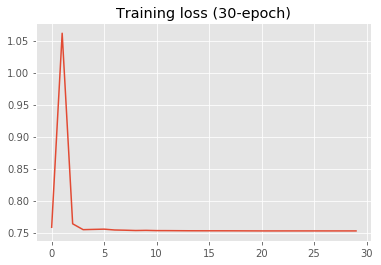

In [0]:
plt.title('Training loss (30-epoch)')
plt.plot(hist)
plt.show()

In [0]:
y_test_pred.shape

torch.Size([252, 4844, 1])

In [0]:
y_test_hat = strip_padding(X_months_test, y_test_pred, y_test)

In [0]:
y_test_hat = np.nan_to_num(y_test_hat.detach().cpu().numpy(), 0)

## Testing Set (Out-Of-Sample) Performance ['2013-01-31', '2018-11-30']

In [0]:
# y_test_hat = clf.predict(X_test)
y_test_hat = pd.DataFrame(y_test_hat, columns=['score'], index=X_test.index)
y_test_hat.insert(0, 'PERMNO', X_test['PERMNO'])
y_test_hat.insert(2, 'y', y_test.values)

In [0]:
test_long_portfolio = y_test_hat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=False).head(100))
test_short_portfolio = y_test_hat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=True).head(100))
test_long_short_portfolio = y_test_hat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=False).head(100).append(x.sort_values('score', ascending=True).head(100)))

### Distribution of actual labels in the constructed long/short portfolios
- In long portfolio, want minimal percentage of stocks actually going to go down next month (with actual label of "-1")
- In short portfolio, want minimal percentage of stocks actually going to go up next month (with actual label of "1")

In [0]:
test_port_performance_df = pd.DataFrame(np.array([[sum(test_long_portfolio['y']==-1) / len(test_long_portfolio), 
                                                   sum(test_long_portfolio['y']==0) / len(test_long_portfolio), 
                                                   sum(test_long_portfolio['y']==1) / len(test_long_portfolio)],
                                                  [sum(test_short_portfolio['y']==-1) / len(test_short_portfolio), 
                                                   sum(test_short_portfolio['y']==0) / len(test_short_portfolio), 
                                                   sum(test_short_portfolio['y']==1) / len(test_short_portfolio)]]), 
                                        columns=[-1,0,1], index=['long', 'short'])
test_port_performance_df.columns.name = 'Actual Label'
test_port_performance_df.index.name = 'Portfolio'
test_port_performance_df

Actual Label,-1,0,1
Portfolio,,,
long,0.257500,0.443333,0.299167
short,0.271806,0.433056,0.295139


### Portfolio Monthly Returns (Out-Of-Sample Period)

In [0]:
test_long_portfolio_copy = test_long_portfolio.copy()
test_long_portfolio_copy = test_long_portfolio_copy.reset_index(level=1, drop=True)
test_long_portfolio_copy = test_long_portfolio_copy.reset_index()
test_long_portfolio_copy = test_long_portfolio_copy.set_index(['date', 'PERMNO'])
testing_returns = pd.DataFrame(testing_set[['TICKER', 'RET_shifted']])
testing_returns = testing_returns.reset_index(level=1)
testing_returns['PERMNO'] = testing_returns['PERMNO'].astype('category')
test_long_portfolio_merged = pd.merge(test_long_portfolio_copy, testing_returns, how='left', on=['date', 'PERMNO'])
test_long_portfolio_merged = test_long_portfolio_merged[['PERMNO', 'TICKER', 'RET_shifted']]
test_long_portfolio_merged = test_long_portfolio_merged.reset_index()
test_long_portfolio_merged = test_long_portfolio_merged.set_index(['date', 'PERMNO'])
test_monthly_long_return = test_long_portfolio_merged.groupby(level=0).mean()
test_monthly_long_return.loc[pd.to_datetime('2018-12-31'), 'RET_shifted'] = np.nan
test_monthly_long_return['return'] = test_monthly_long_return['RET_shifted'].shift()
test_monthly_long_return = test_monthly_long_return[['return']].dropna()
test_monthly_long_return

,return
date,
2013-01-31,0.074302
2013-02-28,0.022458
2013-03-28,0.048824
2013-04-30,0.005441
2013-05-31,0.030652
2013-06-28,-0.007039
2013-07-31,0.073601
2013-08-30,-0.011540
2013-09-30,0.062283


In [0]:
test_monthly_long_return['cum_return'] = test_monthly_long_return['return'].cumsum()

In [0]:
sp500 = pd.read_csv('/gdrive/My Drive/dl-project/repository/sp500.csv', parse_dates=[0], usecols=['Date', 'Adj Close'])
sp500.columns = ['date', 'price']

In [0]:
test_dates = X_test.index.get_level_values('date').unique()

In [0]:
merged = pd.merge(test_monthly_long_return, sp500, how='left', on='date')
merged['sp500_return'] = merged['price'].pct_change()
na_val = sp500[(sp500['date']==test_dates[0]) | (sp500['date']==test_dates[1])]
fill_val = na_val['price'].pct_change().values[1]
merged = merged.fillna(fill_val)

In [0]:
test_sp500_return = merged[['date', 'sp500_return']]
test_sp500_return = test_sp500_return.set_index('date')
test_sp500_return.columns = ['return']
test_sp500_return

,return
date,
2013-01-31,0.050428
2013-02-28,0.011061
2013-03-28,0.035988
2013-04-30,0.018086
2013-05-31,0.020763
2013-06-28,-0.014999
2013-07-31,0.049462
2013-08-30,-0.031298
2013-09-30,0.029750


In [0]:
test_sp500_return['cum_return'] = test_sp500_return['return'].cumsum()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


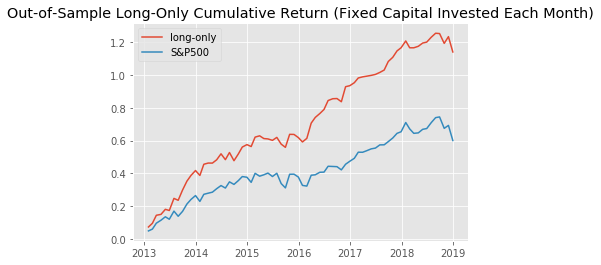

In [0]:
plt.plot(test_monthly_long_return['cum_return'], label='long-only')
plt.plot(test_sp500_return['cum_return'], label='S&P500')
plt.legend()
plt.title('Out-of-Sample Long-Only Cumulative Return (Fixed Capital Invested Each Month)')
plt.show()

In [0]:
test_long_portfolio_merged

TICKER  RET_shifted
date       PERMNO                    
2012-12-31 88319      VC     0.045894
           12570     ITT     0.094629
           60580     TTC     0.024430
           10874      BC     0.243039
           86034     SHS     0.005621
           10104    ORCL     0.065726
           56223     LPX     0.005694
           58683     LUV     0.094727
           90751     DSW     0.018877
           90756     OSK     0.321417
           57817     JWN     0.032336
           57809    NDSN     0.071293
           57665     NKE     0.047481
           57568     BLL    -0.005140
           56573     ITW     0.033218
           56274     CAG     0.116610
           54827    MOLX    -0.006220
           55976     WMT     0.025209
           59010     GPS     0.052835
           53613      MU     0.192429
           90786     ITC     0.053179
           53225     WPO     0.056050
           52978     HAS     0.040947
           90829      CF     0.128027
           52695     GWW     0.076345
           52090     MKC    -0.018574
           52038     SYY     0.012318
           51625     SCI     0.081101
           58819     LNT     0.054657
           59248     TAP     0.055854
           59176     AXP     0.026618
           61399     LOW     0.079673
           64936       D     0.044595
           64311     NSC     0.121766
           64282     LTD     0.020399
           63773     TDS     0.142276
           63765     SWN     0.026639
           62148     CSX     0.116574
           62092     TMO     0.131076
           61815     NBL     0.059465
           90441    NWSA     0.087417
           90505     LVS     0.196924
           61313     DCI     0.145250
           50606     TDW     0.100492
           60986     NWL     0.054333
           60943     LEG     0.081558
           60871     ADI     0.037565
           60687     AFG     0.081857
           60628     FDX     0.106084
           60506    PCAR     0.040920
           60206     SNA     0.025699
           90520      CE     0.052773
           90558     HUN     0.108805
           59328    INTC     0.020369
           50876     LLY     0.088605
           49680     DHR     0.072093
           50278     URS     0.056546
           38658     NVE     0.043550
           40539     TJX     0.064311
           40416     AVP     0.182451
           40125     CSC     0.043695
           39917      WY     0.082674
           39642     BDX     0.074818
           39538     MAT     0.027581
           39490     APA     0.069172
           39087       S    -0.007055
           38762      NI     0.095621
           38659    GNTX     0.021751
           38156     WMB     0.070556
           65330      LM     0.075039
           37284     TSO     0.105335
           37161      TE     0.060263
           36468     SHW     0.054089
           91391     WIN     0.176329
           35051     PLL     0.133422
           34833     OXY     0.152199
           34817     NUE     0.066033
           34032     MAS     0.108343
           32986     ATO     0.063781
           32870     HRL     0.114386
           41080     CMI     0.059806
           41187      HE     0.072792
           41355      PH     0.092993
           42550     NEU    -0.026850
           49429     DDS     0.007640
           49373     HRB     0.226171
           49154     TGT     0.020957
           48725     UNP     0.045657
           91063    VIAB     0.144293
           47941     GCI     0.089950
           46886    KLAC     0.149707
           46877     BCR     0.046347
           46674     GPC     0.069991
           46578     CLX     0.079623
           91143     NYX     0.096068
           44644     ADP     0.041454
           44601     AVY     0.102806
           44206      NU     0.042221
           43772     BMS     0.066348
           43553     VFC    -0.022455
2013-01-31 83822     GES     0.022148
           25487     CAR     0.085462
           51692     PIR     0.035961
           51263     MTW    

In [0]:
test_short_portfolio_copy = test_short_portfolio.copy()
test_short_portfolio_copy = test_short_portfolio_copy.reset_index(level=1, drop=True)
test_short_portfolio_copy = test_short_portfolio_copy.reset_index()
test_short_portfolio_copy = test_short_portfolio_copy.set_index(['date', 'PERMNO'])
test_short_portfolio_merged = pd.merge(test_short_portfolio_copy, testing_returns, how='left', on=['date', 'PERMNO'])
test_short_portfolio_merged = test_short_portfolio_merged[['PERMNO', 'TICKER', 'RET_shifted']]
test_short_portfolio_merged = test_short_portfolio_merged.reset_index()
test_short_portfolio_merged = test_short_portfolio_merged.set_index(['date', 'PERMNO'])
test_monthly_short_return = test_short_portfolio_merged.groupby(level=0).mean()
test_monthly_short_return.loc[pd.to_datetime('2018-12-31'), 'RET_shifted'] = np.nan
test_monthly_short_return['return'] = test_monthly_short_return['RET_shifted'].shift()
test_monthly_short_return = test_monthly_short_return[['return']].dropna()
test_monthly_short_return = -test_monthly_short_return
test_monthly_short_return

,return
date,
2013-01-31,-0.081715
2013-02-28,-0.007122
2013-03-28,-0.039828
2013-04-30,0.004372
2013-05-31,-0.046261
2013-06-28,0.012241
2013-07-31,-0.085550
2013-08-30,0.014480
2013-09-30,-0.055475


In [0]:
test_monthly_short_return['cum_return'] = test_monthly_short_return['return'].cumsum()

In [0]:
test_monthly_long_short_return = (test_monthly_long_return + test_monthly_short_return) / 2

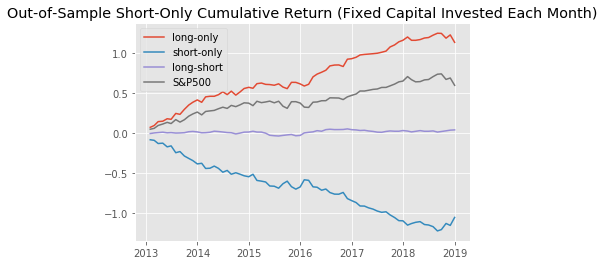

In [0]:
plt.plot(test_monthly_long_return['cum_return'], label='long-only')
plt.plot(test_monthly_short_return['cum_return'], label='short-only')
plt.plot(test_monthly_long_short_return['cum_return'], label='long-short')
plt.plot(test_sp500_return['cum_return'], label='S&P500')
plt.legend()
plt.title('Out-of-Sample Short-Only Cumulative Return (Fixed Capital Invested Each Month)')
plt.show()

In [0]:
test_short_portfolio_merged

TICKER  RET_shifted
date       PERMNO                    
2013-01-31 12622     HCA    -0.014874
           93089    VRSK     0.060007
           79588    GMCR     0.048759
           12872     MPC     0.121547
           91926     DAL     0.027358
...                  ...          ...
2018-11-30 14231    VEEV    -0.071131
           48725     UNP    -0.101119
           85257     AME    -0.076127
           10107    MSFT    -0.084047
           76095    HOLX    -0.074533

[7118 rows x 2 columns]

In [0]:
test_short_portfolio_merged

score  y
date       PERMNO             
2013-01-31 12622  -0.958575 -1
           93089  -0.925265  1
           79588  -0.922351  1
           12872  -0.916932  1
           91926  -0.902201  0
...                     ... ..
2018-11-30 14231  -0.372106  0
           48725  -0.366522  0
           85257  -0.365549  0
           10107  -0.363874  0
           76095  -0.363597  0

[7100 rows x 2 columns]

In [0]:
test_monthly_long_short_return = (test_monthly_long_return + test_monthly_short_return) / 2
test_monthly_long_short_return

,return,cum_return
date,,
2013-02-28,0.004380,0.004380
2013-03-28,0.009106,0.013486
2013-04-30,0.007910,0.021396
2013-05-31,0.010670,0.032065
2013-06-28,0.004082,0.036147
...,...,...
2018-08-31,-0.005166,0.713794
2018-09-28,-0.001571,0.712222
2018-10-31,0.016024,0.728246


In [0]:
test_monthly_long_short_return['cum_return'] = test_monthly_long_short_return['return'].cumsum()

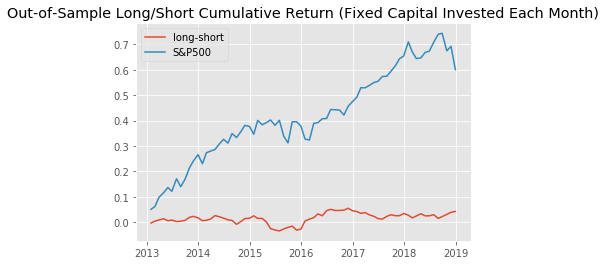

In [0]:
plt.plot(test_monthly_long_short_return['cum_return'], label='long-short')
plt.plot(test_sp500_return['cum_return'], label='S&P500')
plt.legend()
plt.title('Out-of-Sample Long/Short Cumulative Return (Fixed Capital Invested Each Month)')
plt.show()

### Turnover: Percentage of Stocks Changed Compared to Previous Month
- Number of stocks per month = 100
- Number of stocks added = Number of stocks deleted

In [0]:
test_portfolio_sets = pd.DataFrame(test_long_portfolio_merged.groupby(level=0).apply(lambda x: set(x.index.get_level_values(1))), columns=['set'])
test_portfolio_sets['set_shifted'] = test_portfolio_sets['set'].shift()
test_portfolio_sets = test_portfolio_sets.dropna()
test_portfolio_sets.loc[:, 'turnover'] = test_portfolio_sets.copy().apply(lambda x: len(set(x.set).difference(set(x.set_shifted)))/100, axis=1)

test_short_portfolio_sets = pd.DataFrame(test_short_portfolio_merged.groupby(level=0).apply(lambda x: set(x.index.get_level_values(1))), columns=['set'])
test_short_portfolio_sets['set_shifted'] = test_short_portfolio_sets['set'].shift()
test_short_portfolio_sets = test_short_portfolio_sets.dropna()
test_short_portfolio_sets.loc[:, 'turnover'] = test_short_portfolio_sets.copy().apply(lambda x: len(set(x.set).difference(set(x.set_shifted)))/100, axis=1)

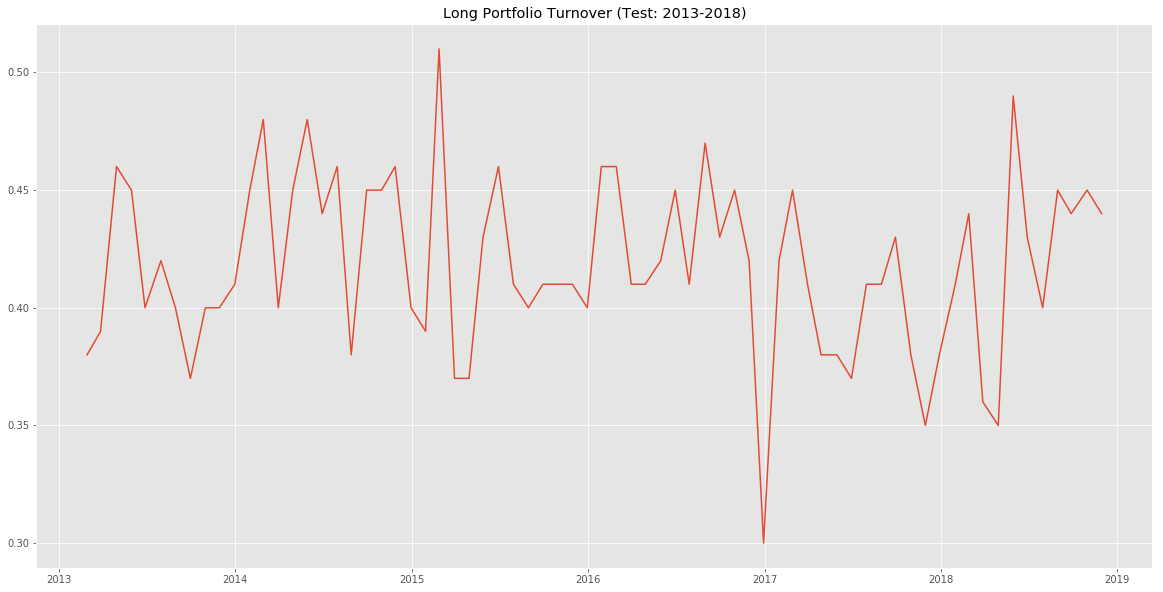

In [0]:
plt.figure(figsize=(20,10))
plt.plot(test_portfolio_sets['turnover'])
plt.title("Long Portfolio Turnover (Test: 2013-2018)")
plt.show()

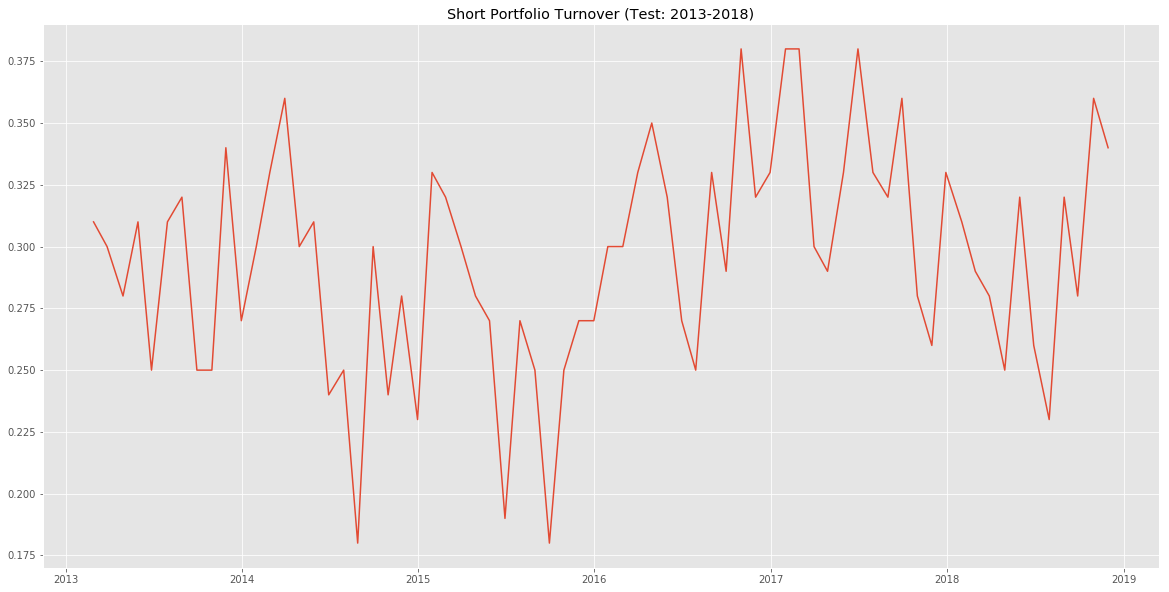

In [0]:
plt.figure(figsize=(20,10))
plt.plot(test_short_portfolio_sets['turnover'])
plt.title("Short Portfolio Turnover (Test: 2013-2018)")
plt.show()

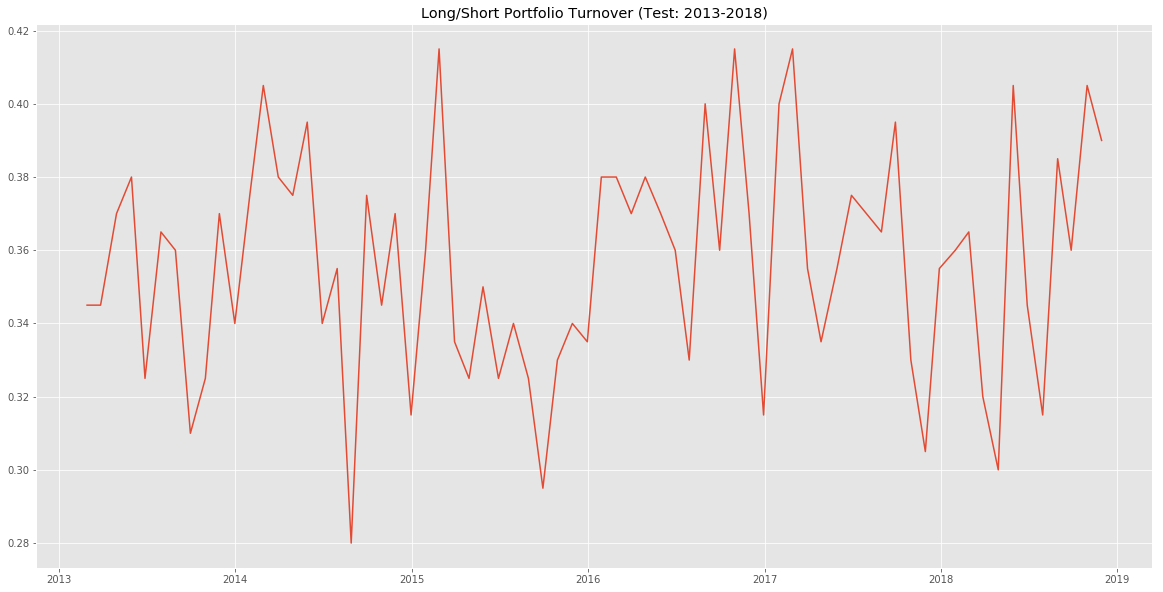

In [0]:
plt.figure(figsize=(20,10))
plt.plot((test_short_portfolio_sets['turnover']+test_portfolio_sets['turnover'])/2)
plt.title("Long/Short Portfolio Turnover (Test: 2013-2018)")
plt.show()

## Long/Short Portfolio Performance Compared to S&P500

In [0]:
merged = pd.merge(test_monthly_long_return, sp500, how='left', on='date')
merged['sp500_return'] = merged['price'].pct_change()
na_val = sp500[(sp500['date']==test_dates[0]) | (sp500['date']==test_dates[1])]
fill_val = na_val['price'].pct_change().values[1]
merged = merged.fillna(fill_val)

test_sp500_return = merged[['date', 'sp500_return']]
test_sp500_return = test_sp500_return.set_index('date')
test_sp500_return.columns = ['return']
test_sp500_return

,return
date,
2013-02-28,0.011061
2013-03-28,0.035988
2013-04-30,0.018086
2013-05-31,0.020763
2013-06-28,-0.014999
...,...
2018-08-31,0.030263
2018-09-28,0.004294
2018-10-31,-0.069403


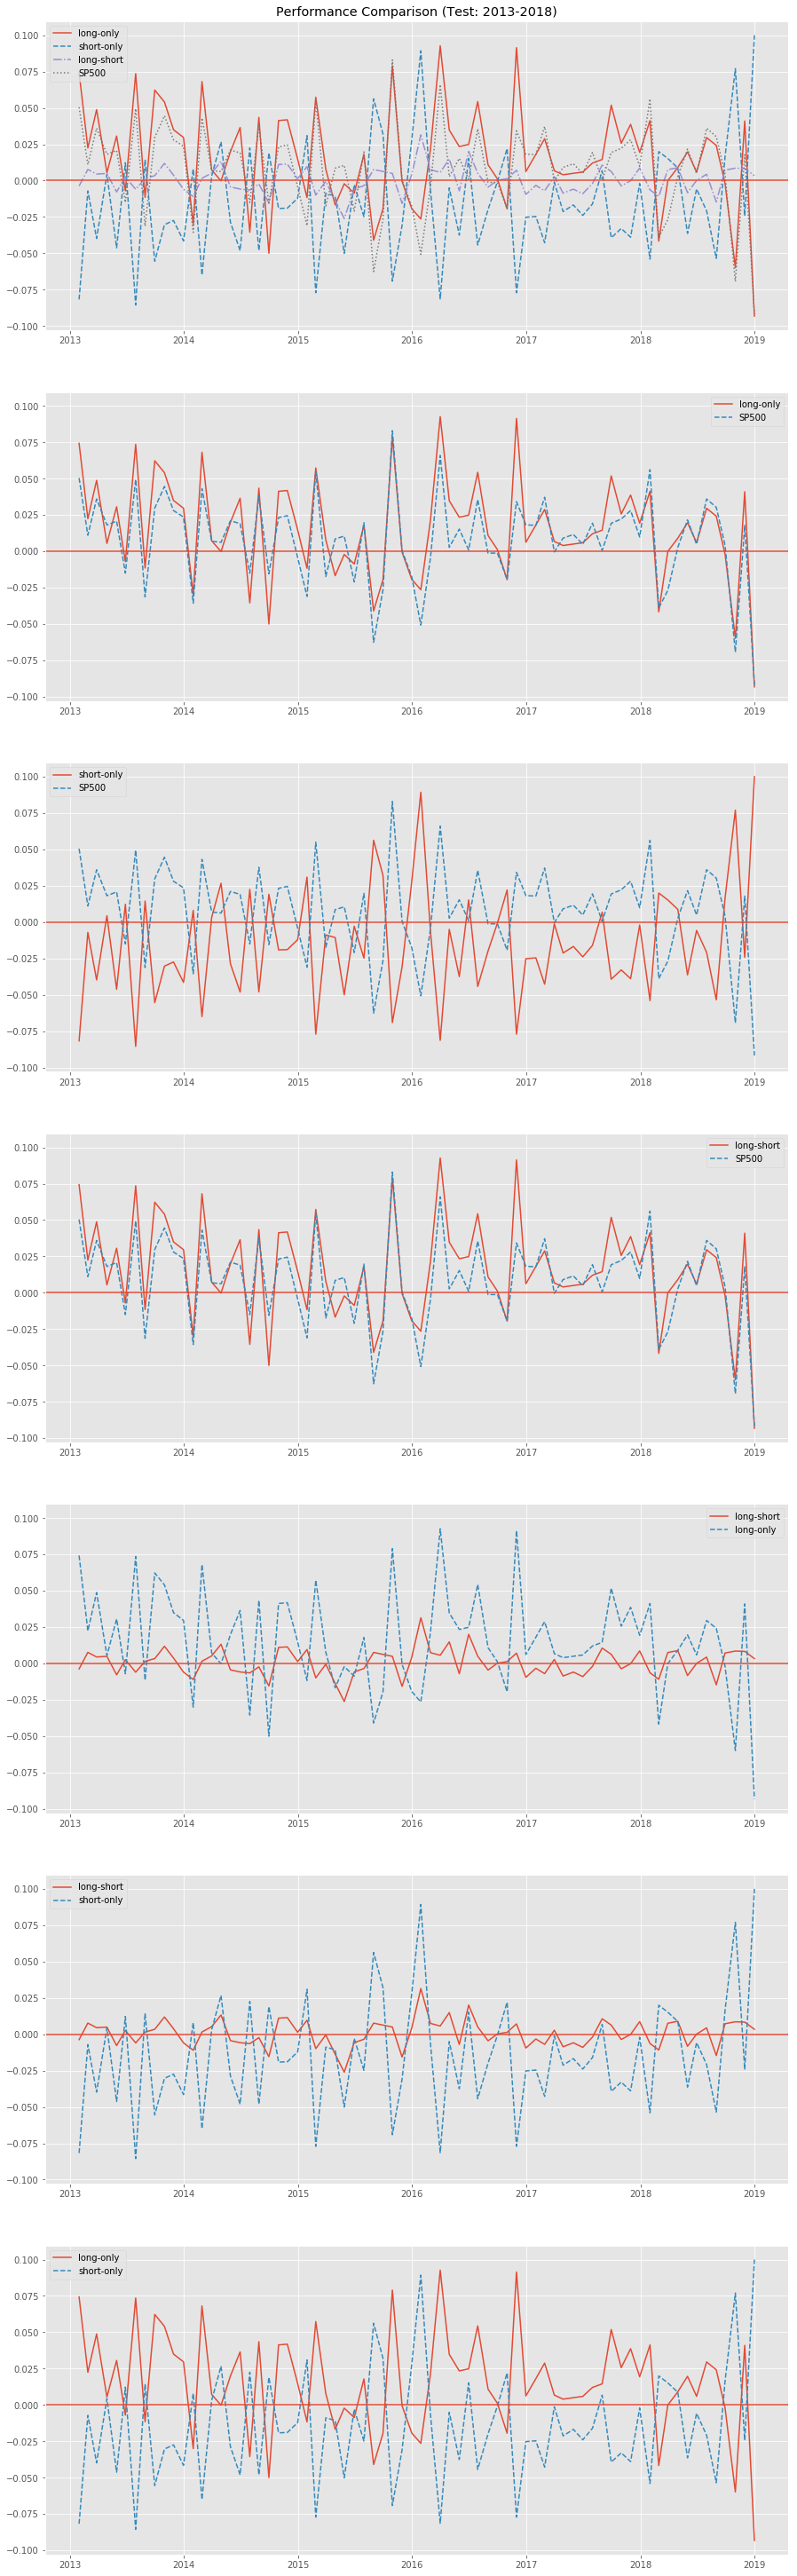

In [0]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=7, ncols=1, sharey=True)
fig.set_figheight(7.5*7)
fig.set_figwidth(15)
ax1.plot(test_monthly_long_return['return'], '-', label='long-only');
ax1.plot(test_monthly_short_return['return'], '--', label='short-only');
ax1.plot(test_monthly_long_short_return['return'], '-.', label='long-short');
ax1.plot(test_sp500_return['return'], ':', label='SP500');
ax1.axhline(0);
ax1.legend();

ax2.plot(test_monthly_long_return['return'], '-', label='long-only');
ax2.plot(test_sp500_return['return'], '--', label='SP500');
ax2.axhline(0);
ax2.legend();

ax3.plot(test_monthly_short_return['return'], '-', label='short-only');
ax3.plot(test_sp500_return['return'], '--', label='SP500');
ax3.axhline(0);
ax3.legend();

ax4.plot(test_monthly_long_return['return'], '-', label='long-short');
ax4.plot(test_sp500_return['return'], '--', label='SP500');
ax4.plot();
ax4.axhline(0);
ax4.legend();

ax5.plot(test_monthly_long_short_return['return'], '-', label='long-short');
ax5.plot(test_monthly_long_return['return'], '--', label='long-only');
ax5.plot();
ax5.axhline(0);
ax5.legend();

ax6.plot(test_monthly_long_short_return['return'], '-', label='long-short');
ax6.plot(test_monthly_short_return['return'], '--', label='short-only');
ax6.plot();
ax6.axhline(0);
ax6.legend();

ax7.plot(test_monthly_long_return['return'], '-', label='long-only');
ax7.plot(test_monthly_short_return['return'], '--', label='short-only');
ax7.plot();
ax7.axhline(0);
ax7.legend();
ax1.set_title('Performance Comparison (Test: 2013-2018)');

In [0]:
test_long_mean = (test_monthly_long_return.values).mean()
test_short_mean = (test_monthly_short_return.values).mean()
test_long_short_mean = (test_monthly_long_short_return.values).mean()
test_sp500_mean = (test_sp500_return.values).mean()
test_long_active_mean = (test_monthly_long_return.values-test_sp500_return.values).mean()
test_short_active_mean = (test_monthly_short_return.values-test_sp500_return.values).mean()
test_long_short_active_mean = (test_monthly_long_short_return.values-test_sp500_return.values).mean()
test_sp500_active_mean = 0
test_long_ir = ((test_monthly_long_return.values-test_sp500_return.values).mean() / (test_monthly_long_return.values-test_sp500_return.values).std()) * np.sqrt(12)
test_short_ir = ((test_monthly_short_return.values-test_sp500_return.values).mean() / (test_monthly_short_return.values-test_sp500_return.values).std()) * np.sqrt(12)
test_long_short_ir = ((test_monthly_long_short_return.values-test_sp500_return.values).mean() / (test_monthly_long_short_return.values-test_sp500_return.values).std()) * np.sqrt(12)
test_sp500_ir = 0
test_long_sr = ((test_monthly_long_return.values).mean() / (test_monthly_long_return.values).std()) * np.sqrt(12)
test_short_sr = ((test_monthly_short_return.values).mean() / (test_monthly_short_return.values).std()) * np.sqrt(12)
test_long_short_sr = ((test_monthly_long_short_return.values).mean() / (test_monthly_long_short_return.values).std()) * np.sqrt(12)
test_sp500_sr = ((test_sp500_return.values).mean() / (test_sp500_return.values).std()) * np.sqrt(12)

In [0]:
test_chart_np = np.array([[test_long_mean, test_long_active_mean, test_long_ir, test_long_sr],
                           [test_short_mean, test_short_active_mean, test_short_ir, test_short_sr],
                           [test_long_short_mean, test_long_short_active_mean, test_long_short_ir, test_long_short_sr], 
                           [test_sp500_mean, test_sp500_active_mean, test_sp500_ir, test_sp500_sr]])
test_chart_df = pd.DataFrame(test_chart_np, columns=['Mean Return', 'Mean Active Return', 'Information Ratio', 'Sharpe Ratio'],
                              index=['long', 'short', 'long/short', 'S&P500'])
print('Testing Set Portfolio Summary Statistics')
test_chart_df

Testing Set Portfolio Summary Statistics


,Mean Return,Mean Active Return,Information Ratio,Sharpe Ratio
long,0.370860,0.157938,2.892868,3.007048
short,-0.354220,-0.567142,-3.032531,-3.012231
long/short,0.008320,-0.204602,-3.055147,1.637733
S&P500,0.212922,0.000000,0.000000,3.059814


In [0]:
print('Pearson Correlation')
test_port_corr = \
pd.DataFrame([test_monthly_long_return['return'], 
              test_monthly_short_return['return'], 
              test_monthly_long_short_return['return'], 
              test_sp500_return['return']], 
             index=['Long', 'Short', 'Long/Short', 'S&P500']).T.corr()
test_port_corr

Pearson Correlation


,Long,Short,Long/Short,S&P500
Long,1.000000,-0.873439,0.093350,0.898237
Short,-0.873439,1.000000,0.403272,-0.904600
Long/Short,0.093350,0.403272,1.000000,-0.161605
S&P500,0.898237,-0.904600,-0.161605,1.000000
